In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Subset
import copy
import math
import random
import matplotlib.pyplot as plt
import pickle

In [2]:
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])

In [3]:
# Training dataset
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = all_transforms,
                                             download = True)

# Testing dataset
test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)

In [4]:
class ModelArchitecture(nn.Module):
    def __init__(self, num_classes):
        super(ModelArchitecture, self).__init__()
        
        # First conv: 3->6 channels, kernel 5x5
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        
        # Second conv: 6->16 channels, kernel 5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        # max pooling after each convolution
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        

        # Two fully-connected layers (120 and 84) with ReLU
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        
        # Final linear + softmax for classification
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Convolution + ReLU + Pool 
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Convolution + ReLU + Pool 
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layer #1 + ReLU
        x = F.relu(self.fc1(x))
        
        # FC layer #2 + ReLU
        x = F.relu(self.fc2(x))
        
        # Final linear + softmax
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

In [5]:
class Client(nn.Module):
    def __init__(self, client_id , 
                 num_classes , x , z , vi , wait_time ,  
                 ti_comp , ti_upload , Ei_comp ,
                 Ei_upload , Ei_batt , Gi , mi ,
                  Pi, N0, s, B):
        
        super(Client, self).__init__()
        self.client_id = client_id
        self.x = x
        self.z = z
        self.vi = vi
        self.wait_time = wait_time
        self.ti_comp = ti_comp
        self.ti_upload= ti_upload
        self.Ei_comp = Ei_comp
        self.Ei_upload = Ei_upload
        self.Ei_batt = Ei_batt
        self.Gi = Gi
        self.mi = mi
        self.Pi        = Pi
        self.N0        = N0
        self.s         = s
        self.B         = B
        self.model = ModelArchitecture(num_classes)
    
    def forward(self, x):
        return self.model(x)
    
    def train_model(self, num_epochs, train_loader, device, criterion, optimizer):
        self.train()
        for epoch in range(num_epochs):
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    def get_weights(self):
        return copy.deepcopy(self.model.state_dict())
    
    def set_weights(self, weights):
        self.model.load_state_dict(weights)

In [6]:
class GREED:
    def __init__(self, alpha_start, alpha_end, K, T, number_of_clients):
        """
        Energy-Aware Client Selection with adaptive alpha schedule.
        :param alpha_start: alpha at round 0
        :param alpha_end: alpha at round K-1
        :param K: total number of global iterations
        :param T: deadline per iteration
        :param number_of_clients: total clients
        """
        self.alpha_start = alpha_start
        self.alpha_end = alpha_end
        self.K = K
        self.T = T
        self.number_of_clients = number_of_clients
        # initialize clients list
        self.clients = self.Initialize_Clients()

    def alpha_schedule(self, k):
        """Linear interpolation of alpha between start and end over K rounds."""
        if self.K <= 1:
            return self.alpha_end
        return self.alpha_start + (self.alpha_end - self.alpha_start) * (k / (self.K - 1))

    def Comp_Latency_and_Energy(self, fi, switched_cap, desired_accuracy, L, d, g, Ci, Di):
        l = math.log2(1 / desired_accuracy)
        u = 2 / (2 - L * d) * d * g
        cycles = Ci * Di * u * l
        return cycles / fi, cycles * switched_cap * (fi ** 2)

    def Up_Latency_and_Energy(self, Pi, hi, N0, s, B):
        ri = B * math.log2(1 + (Pi * hi / N0))
        return s / ri, Pi * (s / ri)

    def Ei_battery(self, Ecomp, Eup, z, vi, x, EiBattery, Emax):
        Gi = z * vi * self.T
        mi = (Ecomp + Eup)*x - Gi
        Eibatt_new = EiBattery - mi

        if Eibatt_new <= 0:
            Eibatt_new = 0
        elif Eibatt_new >= Emax:
            Eibatt_new = Emax
        else : 
            Eibatt_new=Eibatt_new

        return Eibatt_new , Gi , mi

    def Initialize_Clients(self):
        clients = []
        for i in range(self.number_of_clients):
            # computation params
            fi = random.uniform(1.5, 2) * 1e9
            switched_cap = 1e-28
            desired_accuracy = 0.1
            L, d, g = 4, 0.1, 2
            Ci = random.uniform(5,15) * 1e4
            Di = 50
            ti_comp, Ei_comp = self.Comp_Latency_and_Energy(fi, switched_cap, desired_accuracy, L, d, g, Ci, Di)
            # upload params
            distance_km = random.uniform(0.01, 1)
            PL_dB = 128.1 + 37.6 * math.log10(distance_km)
            h_squared = 10 ** (-PL_dB / 10)
            Pi, N0, s, B = 0.01, 1.99e-14, 1e5, 5e6
            ti_upload, Ei_upload = self.Up_Latency_and_Energy(Pi, h_squared, N0, s, B)
            # energy
            z = 0.01e-2
            vi = random.uniform(5,20)
            x = 0
            EiBattery, Emax =   1,1
            Ei_batt, Gi, mi = self.Ei_battery(Ei_comp, Ei_upload, z, vi, x, EiBattery, Emax)
            # create client
            clienti = Client(i, 10, x, z, vi, 0.0, ti_comp, ti_upload,
                 Ei_comp, Ei_upload, Ei_batt, Gi, mi,
                 Pi, N0, s, B)
            clients.append(clienti)
        return clients

    def compute_wait_times(self, selected_clients):
        selected_clients.sort(key=lambda c: c.ti_comp)
        for idx, client in enumerate(selected_clients):
            if idx == 0:
                client.wait_time = 0.0
            else:
                prev = selected_clients[idx - 1]
                delta = prev.ti_comp + prev.wait_time + prev.ti_upload - client.ti_comp
                client.wait_time = max(0.0, delta)
        return selected_clients

    def Client_Selection(self, round_index):
        """
        Select clients at iteration round_index using adaptive alpha.
        """
        alpha_k = self.alpha_schedule(round_index)
        # build candidate list I'
        candidates = []
        for c in self.clients:
            metric = alpha_k * (c.Ei_comp + c.Ei_upload) - (1 - alpha_k)
            c.metric = metric
            # energy feasibility
            if metric < 0 and (c.Gi + c.Ei_batt >= c.Ei_comp + c.Ei_upload):
                candidates.append(c)
        # rank by metric
        candidates.sort(key=lambda c: c.metric)
        # greedy selection
        for c in candidates:
            c.x = 0
        for client_i in candidates:
            client_i.x = 1
            selected = [c for c in candidates if c.x == 1]
            selected = self.compute_wait_times(selected)
            # deadline check
            if any((c.ti_comp + c.wait_time + c.ti_upload) > self.T for c in selected):
                client_i.x = 0
        # return finally selected
        return [c for c in candidates if c.x == 1]


      
 

In [7]:
def Test_GREED(greed, num_rounds):
    """
    Runs the adaptive-GREED selection algorithm for `num_rounds` global iterations,
    records the number of selected clients each round, and plots the results.
    """
    selected_counts = []
    history = {
        'mi_per_client': [],
        'alpha_values': []  # track alpha each round
    }

    for round_index in range(num_rounds):
        # (1) reset selection flag
        for client in greed.clients:
            client.x = 0

        # (2) get and record current alpha
        alpha_k = greed.alpha_schedule(round_index)
        history['alpha_values'].append(alpha_k)

        # (3) select clients adaptively
        selected_clients = greed.Client_Selection(round_index)

        # (4) update each client’s battery & record mi
        mi_dict = {}
        for c in greed.clients:
            # 1) re-draw a distance (or small-scale fading)
            distance_km = random.uniform(0.01, 1)
            PL_dB       = 128.1 + 37.6 * math.log10(distance_km)
            h2          = 10 ** (-PL_dB / 10)

            # 2) recompute upload latency & energy
            c.ti_upload, c.Ei_upload = greed.Up_Latency_and_Energy(
                c.Pi, h2, c.N0, c.s, c.B
            )
            
            x_flag = 1 if c in selected_clients else 0
            new_batt, _, mi = greed.Ei_battery(
                c.Ei_comp, c.Ei_upload, c.z, c.vi, x_flag, c.Ei_batt,1
            )
            c.Ei_batt = new_batt
            c.mi = mi
            mi_dict[c.client_id] = mi
            if c in selected_clients:
                print(f"Selected client {c.client_id} with battery {100*c.Ei_batt:4f}")
            else : print(f"Not Selected client {c.client_id} with battery {100*c.Ei_batt:4f}")
        history['mi_per_client'].append(mi_dict)

        # (5) record how many got selected
        selected_counts.append(len(selected_clients))

    # Plot number of selected clients over iterations
    plt.figure(figsize=(8,5))
    plt.plot(range(1, num_rounds+1), selected_counts,
             label="Adaptive GREED", color="orange")
    plt.xlabel("Global Iteration")
    plt.ylabel("Number of Selected Clients")
    plt.title("Selected Clients vs Global Iterations (Adaptive α)")
    plt.ylim(0, greed.number_of_clients + 5)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot α(k) schedule
    plt.figure(figsize=(8,5))
    plt.plot(range(1, num_rounds+1), history['alpha_values'],
             label="α(k)", color="blue")
    plt.xlabel("Global Iteration")
    plt.ylabel("Alpha Value")
    plt.title("Alpha Schedule over Global Iterations")
    y_min = min(history['alpha_values']) - 0.05
    y_max = max(history['alpha_values']) + 0.05
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.grid(True)
    plt.show()

    return history


Selected client 0 with battery 99.914176
Selected client 1 with battery 99.926278
Selected client 2 with battery 99.985324
Selected client 3 with battery 99.894659
Selected client 4 with battery 99.780553
Selected client 5 with battery 99.983055
Selected client 6 with battery 99.975919
Selected client 7 with battery 99.926573
Selected client 8 with battery 99.863874
Selected client 9 with battery 99.931544
Selected client 10 with battery 100.000000
Selected client 11 with battery 99.829974
Selected client 12 with battery 99.997715
Selected client 13 with battery 99.927960
Not Selected client 14 with battery 100.000000
Selected client 15 with battery 99.998427
Selected client 16 with battery 99.777019
Selected client 17 with battery 100.000000
Selected client 18 with battery 100.000000
Selected client 19 with battery 100.000000
Not Selected client 20 with battery 100.000000
Selected client 21 with battery 100.000000
Selected client 22 with battery 100.000000
Selected client 23 with batt

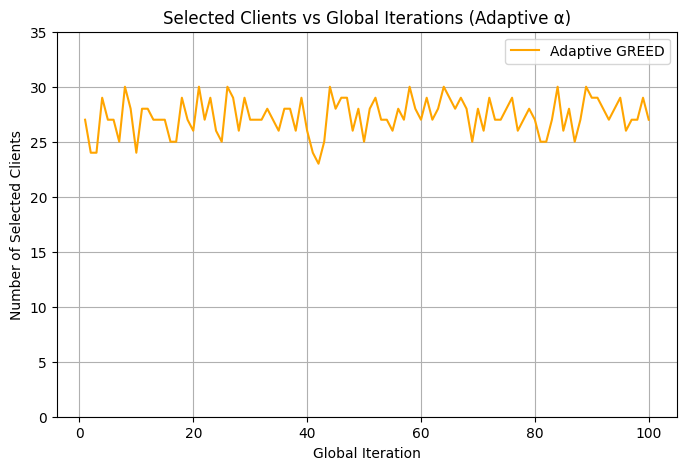

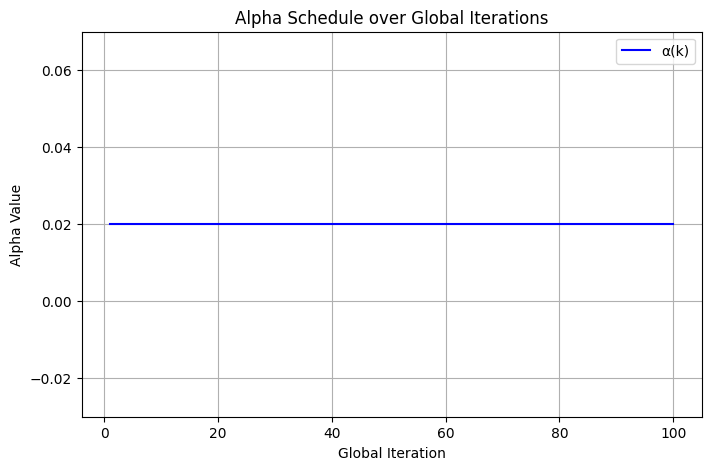

In [303]:
greed = GREED(0.02,0.02,100,1,30)
history=Test_GREED(greed,100
                   )


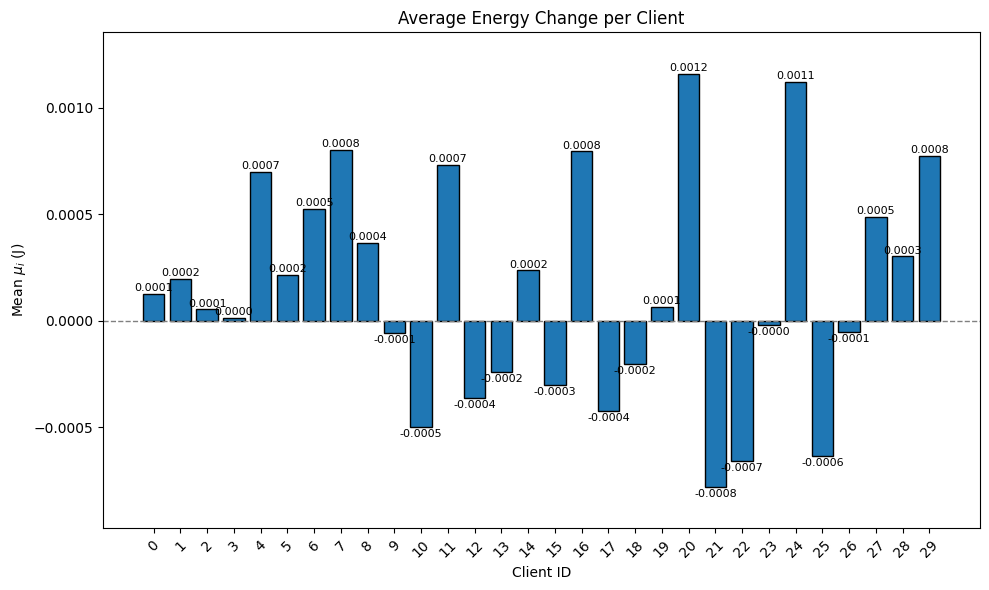

In [304]:
# 1) Build means dict (you already did this)
values_by_key = {}
for d in history["mi_per_client"]:
    for key, value in d.items():
        values_by_key.setdefault(key, []).append(value)

means = {k: np.mean(v) for k, v in values_by_key.items()}

# 2) Sort by mean μ
clients, mean_vals = zip(*sorted(means.items(), key=lambda kv: kv[1]))

# 3) Compute a small padding (10% of the data range)
mn, mx = min(mean_vals), max(mean_vals)
pad = (mx - mn) * 0.1 if mx > mn else abs(mn) * 0.1

# 4) Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(clients, mean_vals, edgecolor="black")
plt.axhline(0, color="gray", linewidth=1, linestyle="--")
plt.xlabel("Client ID")
plt.ylabel("Mean $\\mu_i$ (J)")
plt.title("Average Energy Change per Client")
plt.ylim(mn - pad, mx + pad)
plt.xticks(clients, rotation=45)

# 5) Annotate exact values on top of bars
for bar, val in zip(bars, mean_vals):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + (pad*0.02 if val >= 0 else -pad*0.05),
        f"{val:.4f}",
        ha="center",
        va="bottom" if val>=0 else "top",
        fontsize=8
    )

plt.tight_layout()
plt.show()

In [8]:
class Server(nn.Module):
    def __init__(self, num_classes, number_of_clients):
        super(Server, self).__init__()
        self.num_classes = num_classes
        self.number_of_clients = number_of_clients  
        self.global_model = ModelArchitecture(num_classes)
       
    def forward(self, x):
        return self.global_model(x)
    
    def aggregate_weights(self, client_weights_list):
       
        #Aggregates the weights from multiple clients by computing the average.
        aggregated_weights = copy.deepcopy(client_weights_list[0])
        for key in aggregated_weights.keys():
            for i in range(1, len(client_weights_list)):
                aggregated_weights[key] += client_weights_list[i][key]
            aggregated_weights[key] = aggregated_weights[key] / len(client_weights_list)
        self.global_model.load_state_dict(aggregated_weights)
        return aggregated_weights
    
    def evaluate(self, test_loader, device, criterion):

        #Evaluates the global model on the provided test data.
        self.global_model.eval()  
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.global_model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += images.size(0)
                
        avg_loss = total_loss / total_samples
        accuracy = total_correct / total_samples
        return avg_loss, accuracy
    
    def get_weights(self):
        return copy.deepcopy(self.global_model.state_dict())
    
    def set_weights(self, weights):
        self.global_model.load_state_dict(weights)

In [9]:
#Federated Workflow

def Run_Federated_Workflow(beta, num_rounds, greed_obj, server_obj,
                            device, criterion, clients_train_loaders, test_loader):
    """
    Runs federated training with adaptive-GREED.
    Adds per-round channel resampling and records accuracy vs alpha.
    """
    history = {
        'round': [],
        'test_loss': [],
        'test_accuracy': [],
        'num_of_clients_selected': [],
        'beta': beta,
        'mi_per_client': [],
        'alpha_values': []
    }

    # initialize global model weights
    global_weights = server_obj.get_weights()

    for rnd in range(num_rounds):
        print(f"=== Global Round {rnd+1}/{num_rounds} ===")

        # 1) resample channel and recompute upload for each client
        for c in greed_obj.clients:
            d = random.uniform(0.01, 1)
            PL_dB = 128.1 + 37.6 * math.log10(d)
            h2 = 10 ** (-PL_dB / 10)
            c.ti_upload, c.Ei_upload = greed_obj.Up_Latency_and_Energy(
                c.Pi, h2, c.N0, c.s, c.B
            )

        # 2) get adaptive alpha
        alpha_k = greed_obj.alpha_schedule(rnd)
        history['alpha_values'].append(alpha_k)
        print(f"  [Alpha] α({rnd}) = {alpha_k:.4f}")

        # 3) select clients
        for c in greed_obj.clients:
            c.x = 0
        selected_clients = greed_obj.Client_Selection(rnd)

        # 4) broadcast & local training
        server_obj.set_weights(global_weights)
        for client in selected_clients:
            client.set_weights(global_weights)
            optimizer = optim.SGD(client.model.parameters(), lr=0.01, momentum=0.9)
            train_loader = clients_train_loaders[client.client_id]
            client.train_model(1, train_loader, device, criterion, optimizer)

        # 5) aggregate
        local_weights = [c.get_weights() for c in selected_clients]
        if local_weights:
            server_obj.aggregate_weights(local_weights)
            global_weights = server_obj.get_weights()

        # 6) evaluate
        test_loss, test_acc = server_obj.evaluate(test_loader, device, criterion)
        print(f"  [Server] Loss: {test_loss:.4f}, Acc: {100*test_acc:.2f}% | Selected: {len(selected_clients)}")

        # 7) record history
        history['round'].append(rnd+1)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)
        history['num_of_clients_selected'].append(len(selected_clients))

        # 8) update batteries & record mu
        mi_dict = {}
        for c in greed_obj.clients:
            x_flag = 1 if c in selected_clients else 0
            new_batt, Gi, mi = greed_obj.Ei_battery(
                c.Ei_comp, c.Ei_upload, c.z, c.vi, x_flag, c.Ei_batt, 1
            )
            c.Ei_batt = new_batt
            c.mi = mi
            if c in selected_clients : 
                print(f"Client {c.client_id} Chosen to Participate, Battery: {100*c.Ei_batt:.4f}%")
            else : print(f"Client {c.client_id} Not Chosen, Battery: {100*c.Ei_batt:.4f}%")
            mi_dict[c.client_id] = c.mi
        history['mi_per_client'].append(mi_dict)
        print(f"  [Energy] mi per client: {mi_dict}")
    return history

In [10]:
def partition_dataset_by_dirichlet(dataset,num_clients,
    beta,num_classes,batch_size,shuffle=True,
    num_workers=2
):
    # targets (labels).
    targets = np.array(dataset.targets)
    
    # Group indices of dataset by class label
    class_indices = []
    for c in range(num_classes):
        idxs_c = np.where(targets == c)[0]
        np.random.shuffle(idxs_c)
        class_indices.append(idxs_c)
    

    client_idcs = [[] for _ in range(num_clients)]
    
    for c in range(num_classes):
        # Number of samples in this class
        n_c = len(class_indices[c])
        if n_c == 0:
            continue

        # e.g. [p1, p2, ..., pK] where sum(p_k)=1
        dirichlet_proportions = np.random.dirichlet([beta]*num_clients)
        
        split_counts = (dirichlet_proportions * n_c).astype(int)
        
        diff = n_c - np.sum(split_counts)
        split_counts[-1] += diff
        
        # 3) Allocate the corresponding indices to each client
        start_idx = 0
        for k in range(num_clients):
            num_imgs = split_counts[k]
            end_idx = start_idx + num_imgs
            client_idcs[k].extend(class_indices[c][start_idx:end_idx])
            start_idx = end_idx

    # shuffle each client’s list of indices
    for k in range(num_clients):
        np.random.shuffle(client_idcs[k])
    
    # Create DataLoaders for each client
    clients_loaders = {}
    for k in range(num_clients):
        subset_k = Subset(dataset, client_idcs[k])
        loader_k = DataLoader(subset_k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        clients_loaders[k] = loader_k
    
    return clients_loaders

In [11]:

# Simulation Parameters
batch_size = 50
number_of_clients = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
num_rounds = 100
# Adaptive-α endpoints:
alpha_start = 0.02# high energy preservation at round 0
alpha_end   = 0.02   # more client inclusiveness by final round
T = 1         # per-round deadline (seconds)
num_classes = 10  
beta = 1.0        # Dirichlet concentration

# Global test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Partition training data among clients (Dirichlet non-IID)
clients_train_loaders = partition_dataset_by_dirichlet(
    dataset=train_dataset,
    num_clients=number_of_clients,
    beta=beta,
    num_classes=num_classes,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# Instantiate adaptive-α GREED selector
# Signature: GREED(alpha_start, alpha_end, K, T, number_of_clients)
greed_obj = GREED(
    alpha_start,
    alpha_end,
    num_rounds,
    T,
    number_of_clients
)

# Create the Server
server_obj = Server(num_classes, number_of_clients)

# Run the federated workflow (now uses convergence‐based α internally)
history = Run_Federated_Workflow(
    beta=beta,
    num_rounds=num_rounds,
    greed_obj=greed_obj,
    server_obj=server_obj,
    device=device,
    criterion=criterion,
    clients_train_loaders=clients_train_loaders,
    test_loader=test_loader
)

=== Global Round 1/100 ===
  [Alpha] α(0) = 0.0200
  [Server] Loss: 2.3027, Acc: 9.93% | Selected: 27
Client 0 Not Chosen, Battery: 100.0000%
Client 1 Chosen to Participate, Battery: 99.9559%
Client 2 Chosen to Participate, Battery: 99.8287%
Client 3 Chosen to Participate, Battery: 99.9942%
Client 4 Chosen to Participate, Battery: 100.0000%
Client 5 Chosen to Participate, Battery: 99.9916%
Client 6 Chosen to Participate, Battery: 100.0000%
Client 7 Chosen to Participate, Battery: 100.0000%
Client 8 Not Chosen, Battery: 100.0000%
Client 9 Chosen to Participate, Battery: 99.8681%
Client 10 Chosen to Participate, Battery: 99.9118%
Client 11 Chosen to Participate, Battery: 100.0000%
Client 12 Chosen to Participate, Battery: 99.9404%
Client 13 Chosen to Participate, Battery: 100.0000%
Client 14 Chosen to Participate, Battery: 99.9851%
Client 15 Not Chosen, Battery: 100.0000%
Client 16 Chosen to Participate, Battery: 99.8726%
Client 17 Chosen to Participate, Battery: 99.9513%
Client 18 Chose

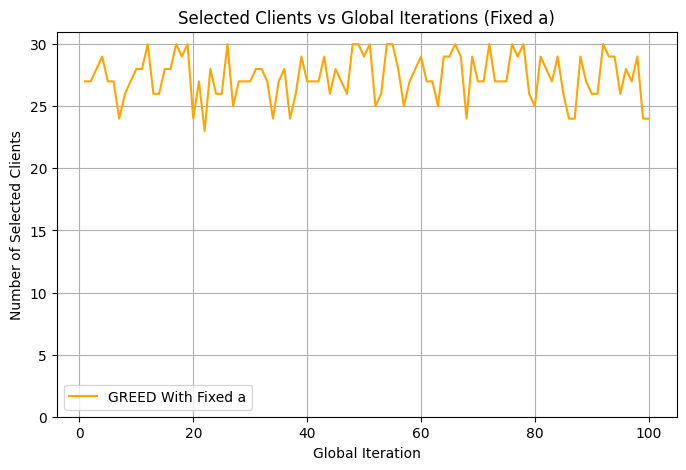

In [12]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_rounds+1), history["num_of_clients_selected"],
             label="GREED With Fixed a", color="orange")
plt.xlabel("Global Iteration")
plt.ylabel("Number of Selected Clients")
plt.title("Selected Clients vs Global Iterations (Fixed a)")
plt.ylim(0, 31)
plt.legend()
plt.grid(True)
plt.show()

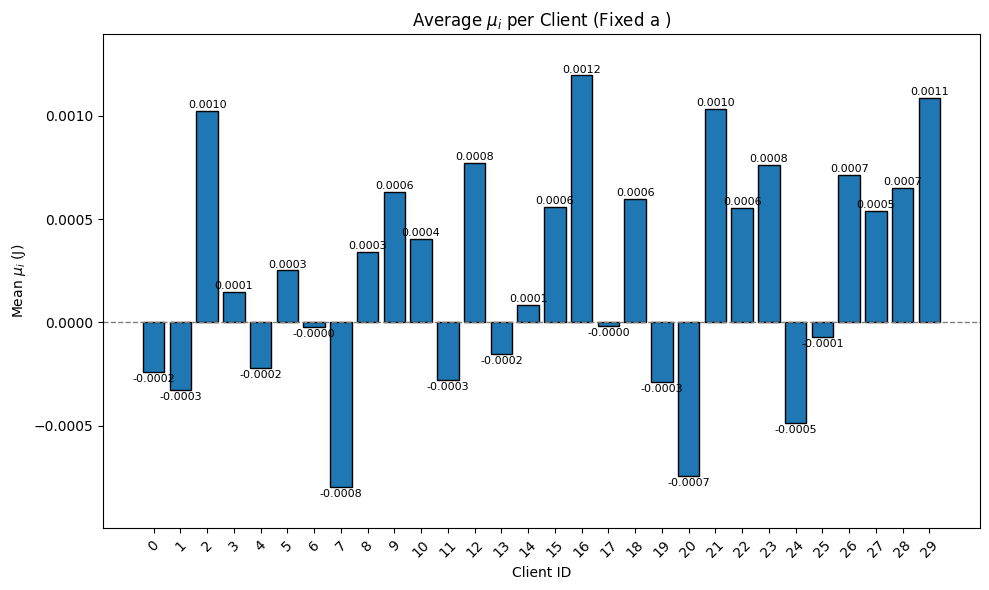

In [13]:

values_by_key = {}
for d in history["mi_per_client"]:
    for key, value in d.items():
        values_by_key.setdefault(key, []).append(value)

means = {k: np.mean(v) for k, v in values_by_key.items()}

# 2) Sort by mean μ
clients, mean_vals = zip(*sorted(means.items(), key=lambda kv: kv[1]))

# 3) Compute a small padding (10% of the data range)
mn, mx = min(mean_vals), max(mean_vals)
pad = (mx - mn) * 0.1 if mx > mn else abs(mn) * 0.1

# 4) Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(clients, mean_vals, edgecolor="black")
plt.axhline(0, color="gray", linewidth=1, linestyle="--")
plt.xlabel("Client ID")
plt.ylabel("Mean $\\mu_i$ (J)")
plt.title("Average $\\mu_i$ per Client (Fixed a )")
plt.ylim(mn - pad, mx + pad)
plt.xticks(clients, rotation=45)

# 5) Annotate exact values on top of bars
for bar, val in zip(bars, mean_vals):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + (pad*0.02 if val >= 0 else -pad*0.05),
        f"{val:.4f}",
        ha="center",
        va="bottom" if val>=0 else "top",
        fontsize=8
    )

plt.tight_layout()
plt.show()

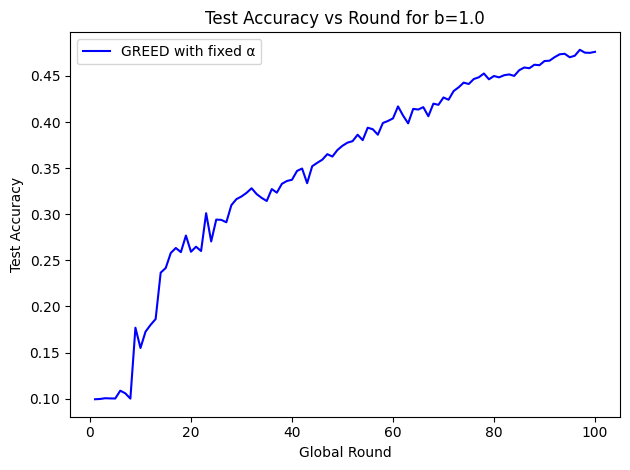

In [14]:
plt.figure()
plt.plot(history["round"], history["test_accuracy"],  label='GREED with fixed α' , color="blue")
plt.xlabel('Global Round')
plt.ylabel(f'Test Accuracy')
plt.title(f'Test Accuracy vs Round for b={beta}')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'pickle' is not defined

NameError: name 'rounds_fix' is not defined

<Figure size 640x480 with 0 Axes>